In [1]:
# data manipulation imports
import numpy as np
import pandas as pd

# data saving imports
import pickle
import os

# custom imports
from regression_class import LogisticRegression as logreg
from regression_class import TimestampClass


In [2]:
# infiles
regression_infile = "regression_thread_data.p"
thread_infile = 'clean_5_thread_data.p'

# outfiles
outdir = 'feature_selection_max_days_v5'
metrics_outfile = "regression_metrics"



In [3]:
models = {
    1: ['log_author_all_activity_count'],
    2: ['activity_ratio'],
    3: ['mean_author_sentiment_sign'],
    4: ['mean_author_sentiment_magnitude'],
    5: ['log_author_all_activity_count', 'activity_ratio'],
    6: ['log_author_all_activity_count', 'mean_author_sentiment_sign'],
    7: ['log_author_all_activity_count', 'mean_author_sentiment_magnitude'],
    8: ['activity_ratio', 'mean_author_sentiment_sign'],
    9: ['activity_ratio', 'mean_author_sentiment_magnitude'],
    10: ['mean_author_sentiment_sign', 'mean_author_sentiment_magnitude'],
    11: ['log_author_all_activity_count', 'activity_ratio', 'mean_author_sentiment_sign'],
    12: ['log_author_all_activity_count', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude'],
    13: ['activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude'],
    14: ['log_author_all_activity_count', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude'],
}
models = logreg.get_sm_modstrings(models, 'success')

In [4]:
# regression params dict
regression_params = {
    'collection_window': 7,
    'validation_window': 7,
    'performance_scoring_method': 'roc_auc',
    'models': models,
    'metrics': ['roc_auc', 'aic']
}

In [6]:
"""
# params
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'hour', 'num_dayofweek','activity_ratio',
    'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude', 'log_author_all_activity_count',
    ]

# regression params dict
regression_params = {
    'collection_window': 7,
    'validation_window': 7,
    'FSS': True,
    'performance_scoring_method': 'roc_auc',
    'x_cols': X_COLS,
    'y_col': 'success',
    'metrics': ['roc_auc', 'aic']
}
"""

"\n# params\nX_COLS = [\n    'sentiment_sign', 'sentiment_magnitude', 'hour', 'num_dayofweek','activity_ratio',\n    'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude', 'log_author_all_activity_count',\n    ]\n\n# regression params dict\nregression_params = {\n    'collection_window': 7,\n    'validation_window': 7,\n    'FSS': True,\n    'performance_scoring_method': 'roc_auc',\n    'x_cols': X_COLS,\n    'y_col': 'success',\n    'metrics': ['roc_auc', 'aic']\n}\n"

In [5]:
# make out params df to save to spreadsheet
out_params = {}
out_params['regression_infile'] = regression_infile
out_params['thread_infile'] = thread_infile

# make out directory
if not os.path.isdir(outdir):
    os.mkdir(outdir)


In [8]:
# read in files
regression_df = pickle.load(open(regression_infile, 'rb'))
thread_df = pickle.load(open(thread_infile, 'rb'))

In [ ]:
for subreddit in ['politics', 'crypto', 'conspiracy', 'books']:
    author_counts = thread_df[subreddit][['id', 'author']].groupby('author').count()
    num_authors = len(author_counts)
    single_activity_authors = author_counts[author_counts.id == 1]
    single_activity_author_num = len(single_activity_authors)
    percentage = single_activity_author_num/num_authors
    print(f"{subreddit}: {percentage*100}%")

politics: 43.31490452855301%
crypto: 46.901869587833914%
conspiracy: 42.32102698650675%
books: 68.04536945270344%


In [9]:
# place to store logregs
subreddit_logregs = {}

In [10]:
# go through subreddits and run regressions
for subreddit in regression_df:
    print(f'###{subreddit}###')
    regression_params['name'] = subreddit
    regression_params['regression_data'] = regression_df[subreddit]
    regression_params['thread_data'] = thread_df[subreddit]

    subreddit_logregs[subreddit] = logreg(regression_params)
    subreddit_logregs[subreddit].main()

###books###
# Period 1 #
Model 1
Optimization terminated successfully.
         Current function value: 0.637798
         Iterations 4
Model 2
Optimization terminated successfully.
         Current function value: 0.629590
         Iterations 5
Model 3
Optimization terminated successfully.
         Current function value: 0.635536
         Iterations 5
Model 4
Optimization terminated successfully.
         Current function value: 0.638101
         Iterations 4
Model 5
Optimization terminated successfully.
         Current function value: 0.629229
         Iterations 5
Model 6
Optimization terminated successfully.
         Current function value: 0.635507
         Iterations 5
Model 7
Optimization terminated successfully.
         Current function value: 0.637754
         Iterations 4
Model 8
Optimization terminated successfully.
         Current function value: 0.628272
         Iterations 5
Model 9
Optimization terminated successfully.
         Current function value: 0.629541
       

In [11]:
pickle.dump(subreddit_logregs, open(f"{outdir}/all_logregs.p", 'wb'))

In [ ]:
subreddit_logregs = pickle.load(open(f"{outdir}/all_logregs.p", 'rb'))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
def plot_metrics_vs_features_one_period(
    regression_metrics,
    period,
    metrics_to_plot,
    name="",
    figsize=(10, 10),
    legend_loc=(1, 1),
    outfile="",
    fontsize=18
):
    """Plot given metrics (aic, auc, bic) on 1 plot for specified model period.

    Parameters
    ----------
    period: int
        model period
    metrics_to_plot : list(str)
        list of metrics to plot
    name : str, optional
        subreddit name, by default ''
    figsize : tuple, optional
        figure size, by default (7,7)
    """
    plt.rcParams.update({'font.size': fontsize})
    plt_colours = list(mcolors.TABLEAU_COLORS.keys())
    fig, ax = plt.subplots(1, figsize=figsize)

    ax_list = [ax]
    if len(metrics_to_plot) > 1:
        ax_list.append(ax.twinx())

    legend_handles = []
    for i, metric in enumerate(metrics_to_plot):
        ax_list[i].plot(
            regression_metrics[period]["metrics"].index,
            regression_metrics[period]["metrics"].loc[:, metric],
            color=plt_colours[i],
            label=f"{metric.upper()}",
        )
        ax_list[i].set_ylabel(metric.upper())
        ax_list[i].tick_params(axis='y', colors=plt_colours[i])
        ax_list[i].yaxis.label.set_color(plt_colours[i])
    
    ax.set_title(
        f"r/{name} information criteria vs number of features"
    )
    ax.set_xlabel("Number of features")
    #fig.legend(bbox_to_anchor=legend_loc)

    if outfile:
        plt.savefig(outfile)

    plt.show()


In [ ]:
for subreddit in subreddit_logregs:
    for period in subreddit_logregs[subreddit].regression_metrics:
        plot_metrics_vs_features_one_period(subreddit_logregs[subreddit].regression_metrics,
            period, ['auc', 'aic'], name=f"{subreddit}", legend_loc=(0.9,0.83),
            outfile=f"{outdir}/{subreddit}_p{period}"
            )

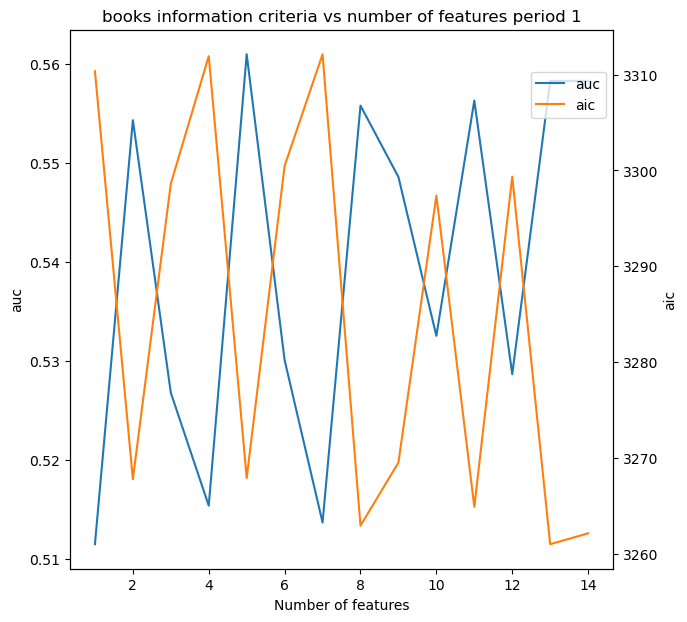

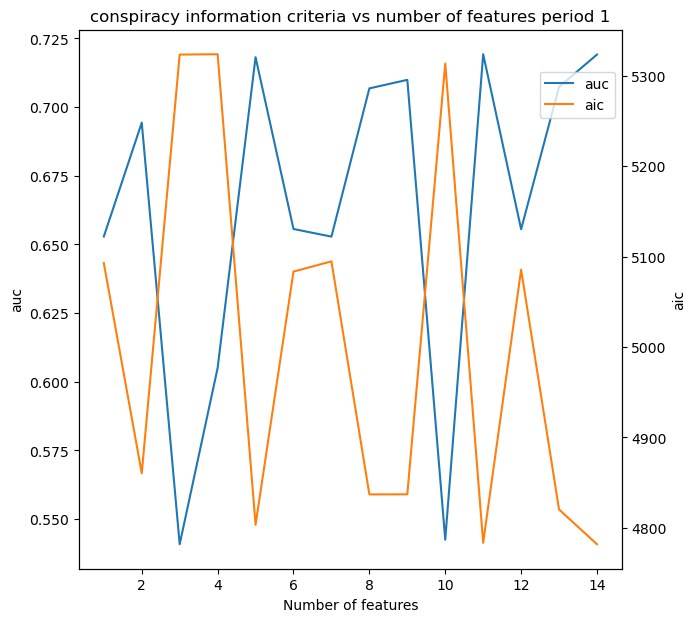

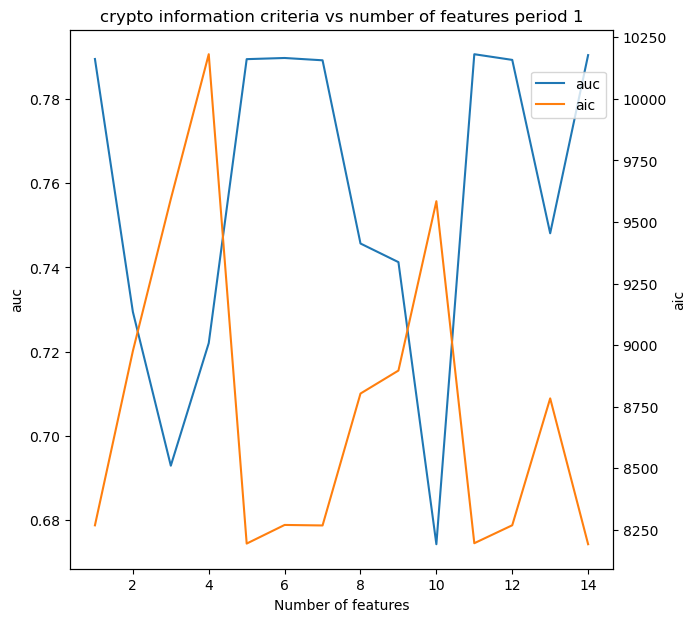

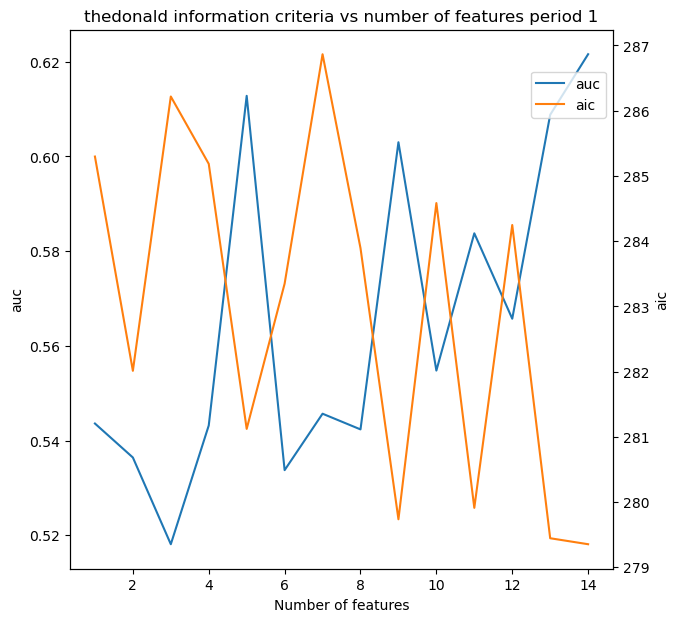

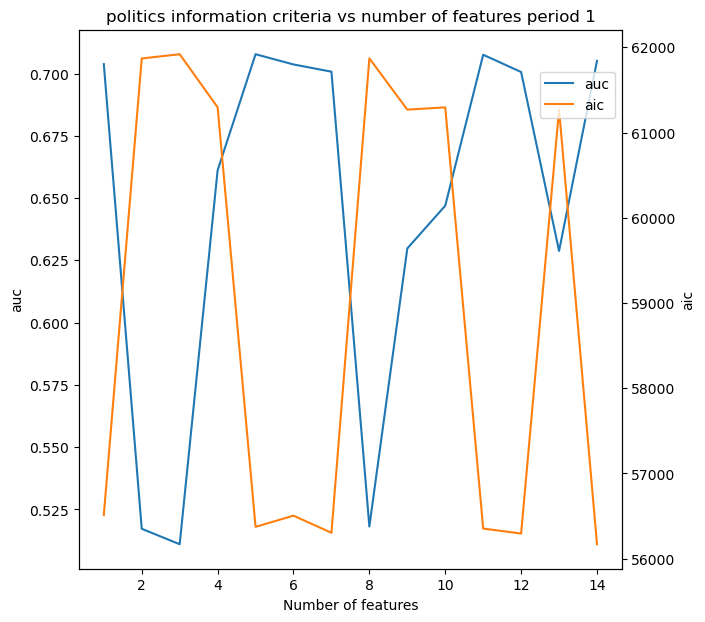

In [12]:
for subreddit in subreddit_logregs:
    for period in subreddit_logregs[subreddit].regression_metrics:
        subreddit_logregs[subreddit].plot_metrics_vs_features_one_period(
            period, ['auc', 'aic'], name=f"{subreddit}", legend_loc=(0.9,0.83),
            outfile=f"{outdir}/{subreddit}_p{period}"
            )

In [ ]:
for subreddit in subreddit_logregs:
    subreddit_logregs[subreddit].get_FSS_metrics_df()

In [21]:
#pickle.dump(subreddit_logregs, open(f"{outdir}/all_logregs.p", 'wb'))
subreddit_logregs = pickle.load(open(f"{outdir}/all_logregs.p", 'rb'))

In [22]:
for subreddit in subreddit_logregs:
    for period in subreddit_logregs[subreddit].regression_metrics:
        subreddit_logregs[subreddit].regression_metrics[period]['metrics'].rename(
            columns={'num_features': 'model_key'}, inplace=True)

        subreddit_logregs[subreddit].regression_metrics[period]['metrics']['num_features'] = (
            subreddit_logregs[subreddit].regression_metrics[period]['metrics'].model.apply(get_feature_num)
        )
        
        subreddit_logregs[subreddit].regression_metrics[period]['metrics'].sort_values(
            'num_features', inplace=True
        )

        

    

In [17]:
def get_feature_num(modstring):
    return len(logreg.get_x_vals_from_modstring(modstring))

In [23]:
for subreddit in subreddit_logregs:
    subreddit_outfile = f"{outdir}/{subreddit}_{metrics_outfile}.xlsx"

    subreddit_logregs[subreddit].output_to_excel(subreddit_outfile, params_to_add=out_params)

        

In [ ]:
subreddit_logregs['books'].regression_metrics

{1: {'regression_params': {1:                    param    stderr        pvalue
   Intercept      -0.684512  0.042003  1.039884e-59
   activity_ratio  0.714947  0.110580  1.009945e-10,
   2:                         param    stderr        pvalue
   Intercept           -0.761737  0.054340  1.209035e-44
   sentiment_magnitude  0.378412  0.165681  2.237251e-02
   activity_ratio       0.710916  0.110605  1.297198e-10,
   3:                                   param    stderr        pvalue
   Intercept                     -0.782494  0.056633  2.012095e-43
   sentiment_magnitude            0.374347  0.165722  2.389055e-02
   activity_ratio                 0.702459  0.109047  1.180672e-10
   log_author_all_activity_count  0.089680  0.067287  1.825991e-01,
   4:                                   param    stderr        pvalue
   Intercept                     -0.890414  0.089293  2.025543e-23
   sentiment_magnitude            0.376546  0.165828  2.316492e-02
   num_dayofweek                  0.03202